# Final Project

## Data Description
### players.csv
- Number of observations: 196
- Number of variables: 9
| Variable   | Description                | Data Type | Example Value   |
|------------|----------------------------|-----------|-----------------|
| `experience` | Player's experience level (e.g. Beginner, Amateur, etc.)      | Categorical (factor)    | `Pro`    |
| `subscribe`      | Whether player has subscribed to PlaiCraft's email updates    | logical   | `TRUE`            |
| `hashedEmail` | Unique hashed email identifier for player | character   | `f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d`          |
| `played_hours`  | Total play time in hours     | double     | `30.3`       |
| `name`| Player's name | character  | `Morgan` |
| `gender`| Player's gender (e.g. Male, Female, etc.) | Categorical (factor)  | `Male` |
| `age`| Player's age in years | integer  | `9` |
| `individualId`| No values provided | N/A  | `NA` |
| `organizationName`| No values provided | N/A  | `NA` |

### sessions.csv
- Number of observations: 1,535
- Number of variables: 5
| Variable   | Description                | Data Type | Example Value   |
|------------|----------------------------|-----------|-----------------|
| `hashedEmail` | Unique hashed email identifier for player | character   | `bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf`          |
| `start_time`      | Start timestamp of the play session (DD/MM/YYYY HH:MM)    | date-time (dttm)   | `30/06/2024 18:12`            |
| `end_time` | End timestamp of the play session (DD/MM/YYYY HH:MM) | date-time (dttm)   | `30/06/2024 18:24`          |
| `original_start_time`  | Scheduled start time in UNIX timestamp format     | double     | `1.71977E+12`       |
| `original_end_time`| Scheduled end time in UNIX timestamp format | double  | `1.71977E+12` |

### Potential Issues
- `individualId` and `organizationName` have no values; `end_time` and `original_end_time` have missing values
- Need to check if all `hashedEmail` values match across the CSV files; only the matches will have data from both CSV files
- Must verify that all timestamps are correct i.e. end times come after start times and the DD/MM/YYYY HH:MM values match the UNIX timestamp values
- Not enough digits in `original_start_time` and `original_end_time` to see any difference between them

## Introduction
Background: A group in Computer Science at UBC is interested in understanding how people play video games. They have set up a server running MineCraft and are recording play sessions. The server is called PlaiCraft.

We are interested in demand forecasting, namely, what time windows are most likely to have large number of simultaneous players. This is because we need to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability.

Our project focuses on the second question: What time windows are most likely to have large number of simultaneous players? This insight is critical for demand forecasting to ensure that we maintain a sufficient number of licenses to accommodate all players concurrently with a high probability. 

Our analysis will involve the number of simultaneous players at a given time (response variable), session start and end times (explanatory variables).

Specific Question: Can `time_of_day`, `day_of_week`, `month`, `experience`, and `session_duration` accurately predict the number of simultaneous players (`player_count`) over a 1-hour time window using K-NN regression?

We will calculate `time_of_day`, `day_of_week`, `month`, `session_duration` from `start_time` and `end_time`, and `player_count` using 1-hour time windows over the time range in the data.

Note: we are not using `age`, `subscribe`, or `gender` because they are unreliable - many participants lie about their age and gender and subscribe is unlikely to be indicative of play time.

## Exploratory Data Analysis and Visualization

In [38]:
library(repr)
library(tidyverse)
library(tidymodels)

In [39]:
# show dataset can be loaded into R
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"

players <- read_csv(players_url)
sessions <- read_csv(sessions_url)

# players
# sessions

# get names of columns with missing/NA values (for data description)
players_na_cols <- players |>
    select_if(~ any(is.na(.))) |>
    names()
players_na_cols

sessions_na_cols <- sessions |>
    select_if(~ any(is.na(.))) |>
    names()
sessions_na_cols

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "individualId"     "organizationName"

[1] "end_time"          "original_end_time"

In [40]:
# individualId and organizationName not needed b/c they are empty
# data is already tidy - each row is a single observation (unique player), each column is a single variable, each value is a single cell
players_tidy <- select(players, -individualId, -organizationName)
head(players_tidy)

experience,subscribe,hashedEmail,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [41]:
# digits given in original_start_time and original_end_time are not specific enough to get any difference between the 2 columns, can remove
# data is already tidy - each row is a single observation (play session), each column is a single variable, each value is a single cell
sessions_tidy <- sessions |>
    select(-original_start_time, -original_end_time) |>
    mutate(
        start_time = dmy_hm(start_time), # convert to POSIXct using lubridate::dmy_hm()
        end_time = dmy_hm(end_time)
        )
head(sessions_tidy)

hashedEmail,start_time,end_time
<chr>,<dttm>,<dttm>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


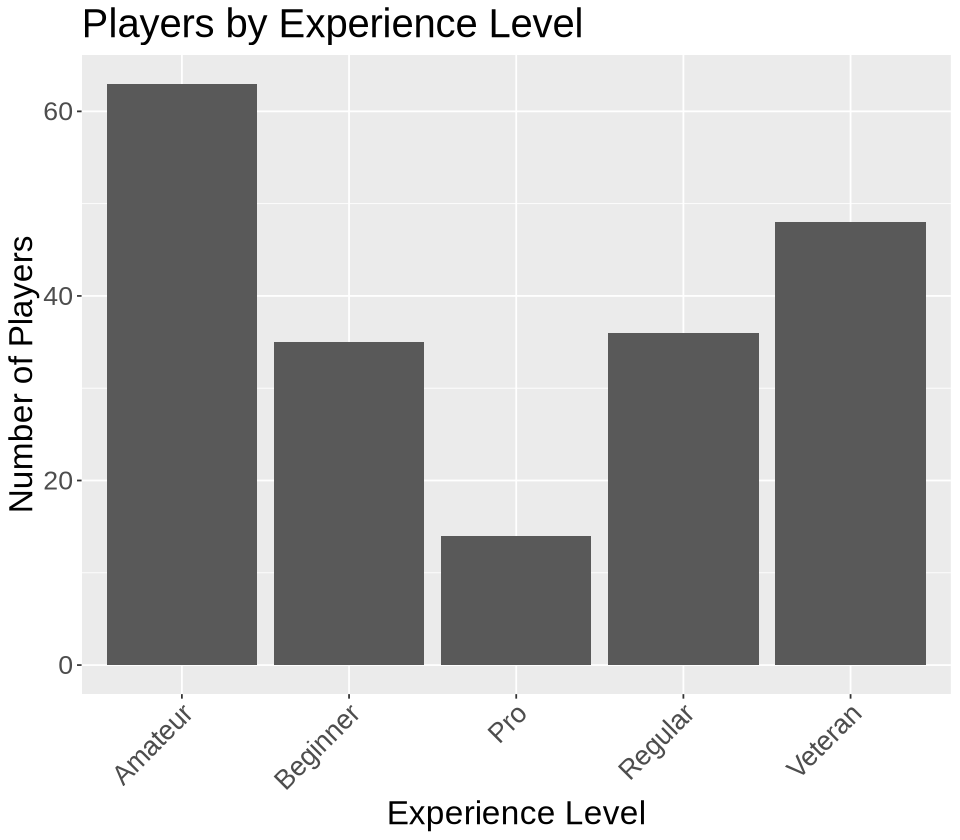

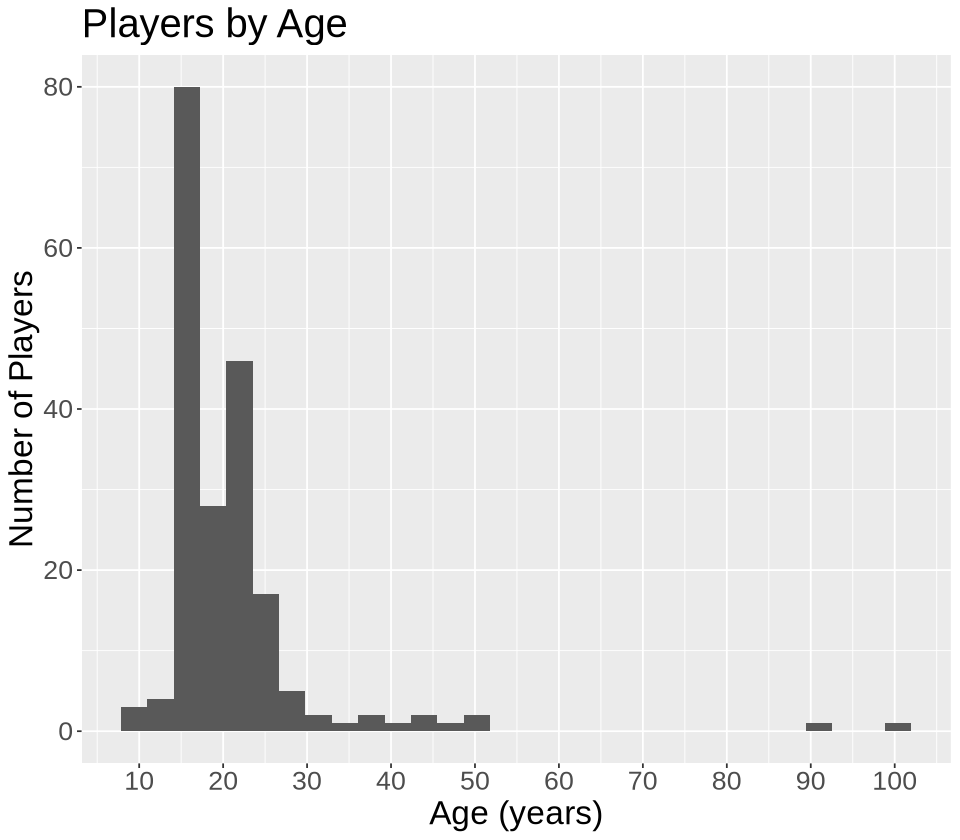

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_summary()`).”


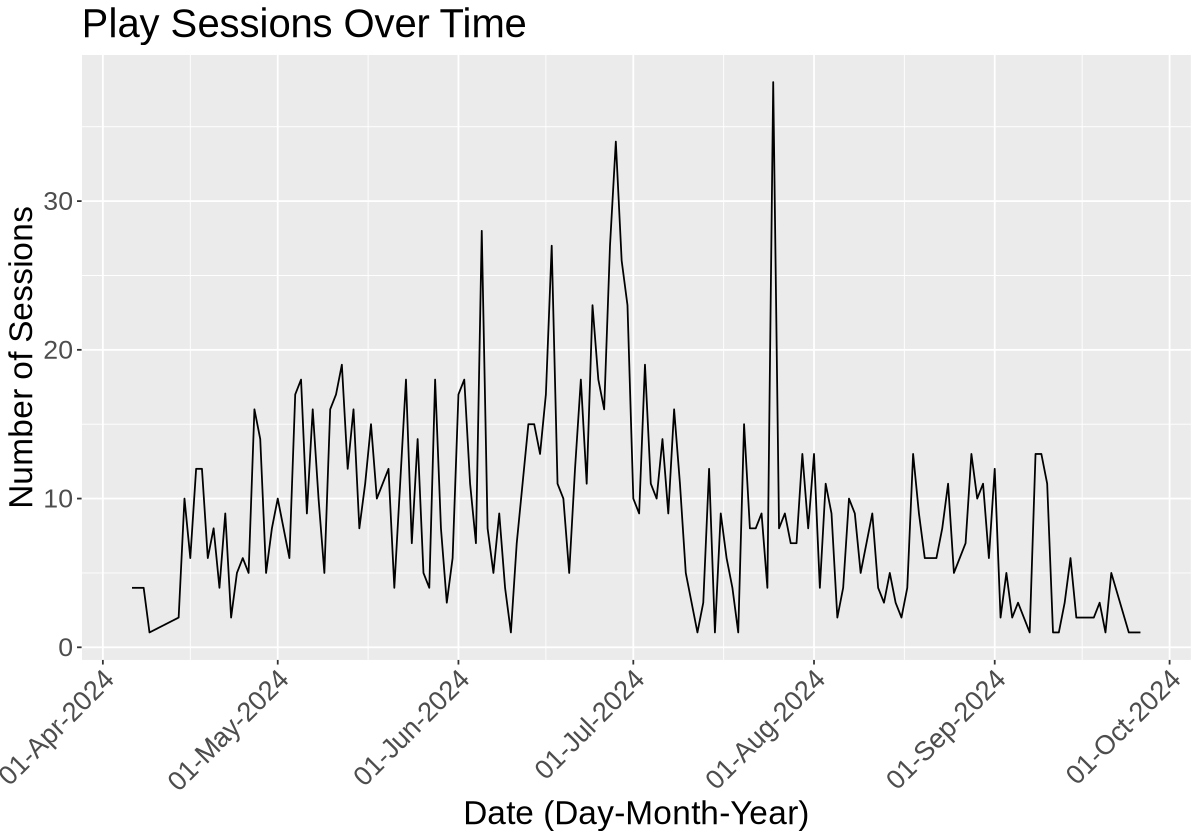

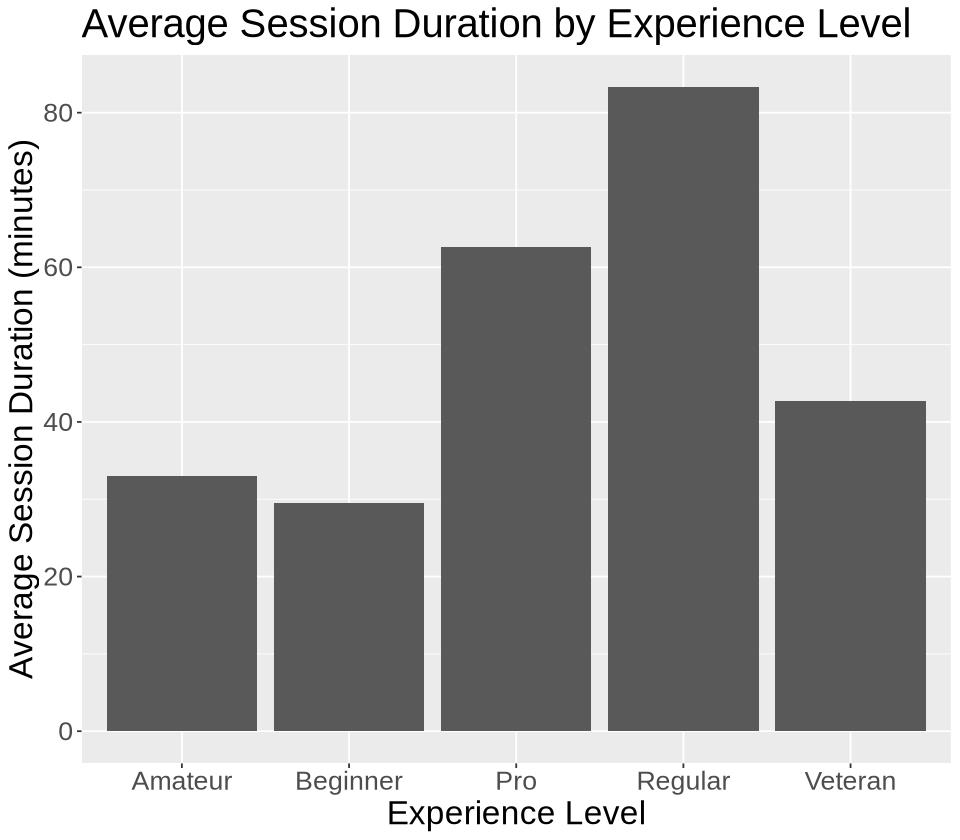

In [42]:
# Visualizations
# Distribution of players by experience level plot
options(repr.plot.width = 8, repr.plot.height = 7)
players_by_exp_plot <- ggplot(players_tidy, aes(x = experience)) +
  geom_bar() +
  labs(
    title = "Players by Experience Level",
    x = "Experience Level",
    y = "Number of Players"
  ) +
  theme(
      text = element_text(size = 20),
      axis.text.x = element_text(angle = 45, hjust = 1)
  )
players_by_exp_plot

# Distribution of players by age plot
# Default with 30 bins looks good
players_by_age_plot <- ggplot(players_tidy, aes(x = age)) +
  geom_histogram() +
  labs(
    title = "Players by Age",
    x = "Age (years)",
    y = "Number of Players"
  ) +
    scale_x_continuous(
    breaks = seq(0, 100, by = 10)  # set breaks at every 10 years
    ) +
  theme(text = element_text(size = 20))
players_by_age_plot

# Sessions over time plot
options(repr.plot.width = 10, repr.plot.height = 7)
session_counts <- sessions_tidy |>
    mutate(start_date = as.Date(start_time)) |>
    group_by(start_date) |>
    summarise(session_count = n())

sessions_time_plot <- ggplot(session_counts, aes(x = start_date, y = session_count)) +
  geom_line() +
  labs(
    title = "Play Sessions Over Time",
    x = "Date (Day-Month-Year)",
    y = "Number of Sessions"
  ) +
  theme(
      text = element_text(size = 20),
       axis.text.x = element_text(angle = 45, hjust = 1)
       ) +
  scale_x_date(
    date_labels = "%d-%b-%Y",  # Day-Month-Year format
    date_breaks = "1 month"     # breaks every month
  )
sessions_time_plot

# Average session duration by experience level plot
# left join using hashedEmail
sessions_players_joined <- left_join(sessions_tidy, players_tidy, by = "hashedEmail") |>
  mutate(
    session_duration = as.numeric(difftime(end_time, start_time, units = "mins"))
  )

options(repr.plot.width = 8, repr.plot.height = 7)
avg_session_exp_plot <- ggplot(sessions_players_joined, aes(x = experience, y = session_duration)) +
  geom_bar(stat = "summary", fun = "mean") +  # mean session duration
  labs(title = "Average Session Duration by Experience Level",
       x = "Experience Level",
       y = "Average Session Duration (minutes)") +
  theme(text = element_text(size = 20))
avg_session_exp_plot

### Relevant Insights
- Players by Age histogram shows a skewed distribution with most players between ages 10 and 25, suggesting the relationship between age and other variables may not be linear
- Play Time vs Age scatter plot has most points clustered near the bottom with some outliers spread out, appears non-linear, high variation in play time
- Play Sessions Over Time line plot oscillates wildly, appears non-linear

In [75]:
# left join using hashedEmail
sessions_players_joined <- left_join(sessions_tidy, players_tidy, by = "hashedEmail") |>
  mutate(
    session_duration = as.numeric(difftime(end_time, start_time, units = "mins"))
  ) |>
    filter(!is.na(end_time)) # filter out any rows with NA values

head(sessions_players_joined)

time_windows <- data.frame(
  time_window = seq(from = floor_date(min(sessions_players_joined$start_time), "hour"), 
                    to = ceiling_date(max(sessions_players_joined$end_time), "hour"), 
                    by = "hour")
)
head(time_windows)

# perform a cross join between sessions and time windows
player_counts <- time_windows |>
  # use expand_grid to generate all combinations of time_window and sessions
  expand_grid(session = sessions_players_joined) |>
  # filter for sessions that overlap with the time window
  filter(session$start_time < time_window + hours(1) & session$end_time > time_window) |>
  # group by time_window to get player count, most frequent experience level, and total session duration
  group_by(time_window) |>
  summarise(
    player_count = n(),  # count number of sessions overlapping the time window
    most_frequent_experience = names(sort(table(session$experience), decreasing = TRUE))[1],  # Most frequent experience level
    total_session_duration = sum(session$session_duration, na.rm = TRUE),  # Sum of session durations
    .groups = "drop"
  ) |>
    mutate(
    month = month(time_window, label = TRUE),      # month (Jan, Feb, ..., Dec)
    day_of_week = wday(time_window, label = TRUE),  # day of the week (Mon, Tue, ..., Sun)
    hour = hour(time_window)                      # hour (0-23)
  )

head(player_counts)

# one-hot encoding the categorical variables
player_counts_encoded <- player_counts |>
  mutate(
    most_frequent_experience = as.factor(most_frequent_experience),  # convert to factor for one-hot encoding
    month = as.factor(month),
    day_of_week = as.factor(day_of_week)
  ) |>
  # one-hot encode using model.matrix
  bind_cols(
    model.matrix(~ most_frequent_experience - 1, data = player_counts)[, -1],  # remove intercept column, one-hot encode most_frequent_experience
    model.matrix(~ month - 1, data = player_counts)[, -1],  # one-hot encode month
    model.matrix(~ day_of_week - 1, data = player_counts)[, -1]  # one-hot encode day_of_week
  )

head(player_counts_encoded)

hashedEmail,start_time,end_time,experience,subscribe,played_hours,name,gender,age,session_duration
<chr>,<dttm>,<dttm>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,Regular,TRUE,223.1,Hiroshi,Male,17,12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,Amateur,TRUE,53.9,Alex,Male,17,13
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,Amateur,TRUE,150.0,Delara,Female,16,23
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,Regular,TRUE,223.1,Hiroshi,Male,17,36
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,Amateur,TRUE,53.9,Alex,Male,17,11
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,Regular,TRUE,223.1,Hiroshi,Male,17,122


,time_window
,<dttm>
1,2024-04-06 09:00:00
2,2024-04-06 10:00:00
3,2024-04-06 11:00:00
4,2024-04-06 12:00:00
5,2024-04-06 13:00:00
6,2024-04-06 14:00:00


time_window,player_count,most_frequent_experience,total_session_duration,month,day_of_week,hour
<dttm>,<int>,<chr>,<dbl>,<ord>,<ord>,<int>
2024-04-06 09:00:00,2,Amateur,45,Apr,Sat,9
2024-04-06 10:00:00,1,Amateur,41,Apr,Sat,10
2024-04-06 20:00:00,1,Amateur,68,Apr,Sat,20
2024-04-06 21:00:00,1,Amateur,68,Apr,Sat,21
2024-04-06 22:00:00,2,Amateur,137,Apr,Sat,22
2024-04-06 23:00:00,1,Pro,69,Apr,Sat,23


time_window,player_count,most_frequent_experience,total_session_duration,month,day_of_week,hour,most_frequent_experienceBeginner,most_frequent_experiencePro,most_frequent_experienceRegular,⋯,monthSep,monthOct,monthNov,monthDec,day_of_weekMon,day_of_weekTue,day_of_weekWed,day_of_weekThu,day_of_weekFri,day_of_weekSat
<dttm>,<int>,<fct>,<dbl>,<ord>,<ord>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-04-06 09:00:00,2,Amateur,45,Apr,Sat,9,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
2024-04-06 10:00:00,1,Amateur,41,Apr,Sat,10,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
2024-04-06 20:00:00,1,Amateur,68,Apr,Sat,20,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
2024-04-06 21:00:00,1,Amateur,68,Apr,Sat,21,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
2024-04-06 22:00:00,2,Amateur,137,Apr,Sat,22,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
2024-04-06 23:00:00,1,Pro,69,Apr,Sat,23,0,1,0,⋯,0,0,0,0,0,0,0,0,0,1


## Methods and Plan
- Do K-NN regression as the data appear non-linear and a simplistic, clean approach:
    - We do not need extrapolation because we are looking at times in a set 24 hour range with the same days in the week and months in the year
    - Assumptions: similar observations will have similar outcomes, no strong assumptions about data distribution
    - Strengths: works well with non-linear relationships, suitable for our dataset
- Calculate `time_of_day`, `day_of_week`, `month`, `session_duration` from `start_time` and `end_time`
- Calculate `player_count` using 1-hour time windows over the time range in the data
    - Can widen time window beyond 1-hour if computationally too expensive or narrow it if further granularity is needed
- One-hot encode categorical variables `subscribe`, `month`, and `gender`
- Split data (initial split) into training and test sets with a proportion of 0.70 (70% training and 30% testing) as this is standard
- Use forward selection to determine which of `time_of_day`, `day_of_week`, `month`, `experience`, `age`, `session_duration`, `subscribe`, and `gender` are suitable predictors and update model accordingly i.e. repeat the following for each model, starting from 1 predictor and iteratively adding more if suitable:
    - Scale and center all predictors
    - Tune for k in between 1 and 200, pick best k using RMSPE from 5-fold cross-validation, which is standard
    - Evaluate model on test set using best k

### Limitations
- Very slow with large training set
- May not perform well with a large number of predictors
- Unsuitable for extrapolation (predicting beyond the range of values in training data)
- May not perform well with sparse data